In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
from skimpy import skim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pdb
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
np.random.seed(42)
# import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import pdb
import xgboost as xgb

# from pandas_profiling import ProfileReport

In [4]:
# subdirs = os.listdir('/Users/awxlong/Desktop/my-studies/temp_data/CRC/TCGA-CRC/gdc_download_20240629_132916.799980/')
cohort_name = 'COAD'
task_name = 'g0_arrest'
# Parent directory containing subdirectories with XML files
# parent_directory = '/Users/awxlong/Desktop/my-studies/temp_data/CRC/TCGA-CRC/gdc_download_20240629_132916.799980/'
root_dir = '/Users/awxlong/Desktop/my-studies/hpc_exps/Data/'

df = pd.read_csv(f'{root_dir}{cohort_name}_WSI_clinical_g0_arrest_features.csv')


In [15]:
df.shape
df['PatientID'].drop_duplicates().shape

(570,)

In [5]:
def train_val_test_split(df):
  df_train_val, df_test = train_test_split(df, test_size=0.1, random_state=42)
  df_train, df_val =  train_test_split(df_train_val, test_size=0.2, random_state=42)
  return df_train, df_val, df_test



In [6]:
# df['Primary Lymph Node Presentation Assessment'].value_counts()
# # df['Lymph Node Examined Count'].value_counts()
# df['Non Nodal Tumor Deposits'].value_counts(dropna=False)
# df['Venous Invasion'].value_counts(dropna=False)
# df['Kras Mutation Found'].value_counts(dropna=False)
# df['Braf Gene Analysis Result'].value_counts(dropna=False)
# df['Synchronous Colon Cancer Present'].value_counts()
# df['Colon Polyps Present'].value_counts(dropna=False)
# df['Loss Expression Of Mismatch Repair Proteins By Ihc'].value_counts()
# df['Number Of First Degree Relatives With Cancer Diagnosis'].value_counts()
# df['Postoperative Rx Tx'].value_counts(dropna=False)
# df['New Tumor Event After Initial Treatment'].value_counts()
# df['Prescribed Dose'].value_counts()
# df['Number Cycles'].value_counts()
# df['Measure Of Response'].value_counts()

In [7]:
print(df.shape)
df.head()

(578, 33)


,Unnamed: 0,PatientID,g0_arrest,Gender,Weight,Age At Initial Pathologic Diagnosis,Race,Other Dx,Pathologic Stage,Icd O 3 Histology,...,Preoperative Pretreatment Cea Level,Non Nodal Tumor Deposits,Kras Mutation Found,Braf Gene Analysis Result,Loss Expression Of Mismatch Repair Proteins By Ihc,Postoperative Rx Tx,New Tumor Event After Initial Treatment,Prescribed Dose,Number Cycles,Measure Of Response
0,0,TCGA-AA-A03J,1,FEMALE,NaN,65.0,NaN,No,Stage I,8140/3,...,2.09,NaN,NaN,NaN,NO,NaN,NaN,Unknown,Unknown,Unknown
1,1,TCGA-AZ-4682,0,MALE,98.0,61.0,WHITE,No,Stage IVA,8140/3,...,NaN,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,TCGA-AD-6963,0,MALE,107.0,58.0,WHITE,No,NaN,8140/3,...,5.50,NO,NaN,NaN,NO,NaN,NaN,Unknown,Unknown,Unknown
3,3,TCGA-AA-3979,1,MALE,NaN,84.0,NaN,Yes,Stage IIA,8140/3,...,NaN,NaN,NaN,NaN,NO,NaN,NaN,Unknown,Unknown,Unknown
4,4,TCGA-AA-A01Z,1,MALE,NaN,68.0,NaN,No,Stage II,8140/3,...,18.87,NaN,NaN,NaN,NO,NaN,NaN,Unknown,Unknown,Unknown


In [8]:
df['g0_arrest'].value_counts()

g0_arrest
0    295
1    283
Name: count, dtype: int64

In [9]:
df['Gender'].value_counts()

Gender
MALE      302
FEMALE    274
Name: count, dtype: int64

In [10]:
df['Race'].value_counts()

Race
WHITE                               269
BLACK OR AFRICAN AMERICAN            71
ASIAN                                12
AMERICAN INDIAN OR ALASKA NATIVE      1
Name: count, dtype: int64

In [11]:
df['Other Dx'].value_counts()

Other Dx
No                                                  523
Yes                                                  52
Yes, History of Synchronous/Bilateral Malignancy      1
Name: count, dtype: int64

### icd codes

In [12]:
def replace_icd_o_3_site(df, column_name):
    icd_o_3_site_map = {
        'C18.0': 'Cecum',
        'C18.2': 'Ascending colon',
        'C18.3': 'Hepatic flexure of colon',
        'C18.4': 'Transverse colon',
        'C18.5': 'Splenic flexure of colon',
        'C18.6': 'Descending colon',
        'C18.7': 'Sigmoid colon',
        'C18.9': 'Colon, NOS (Not Otherwise Specified)',
        'C19.9': 'Rectosigmoid junction',
        'C20.9': 'Rectum, NOS',
        'C49.4': 'Connective and soft tissue of abdomen',
        'C80.9': 'Unknown primary site'
    }
    
    # Replace the codes with their meanings
    df[column_name] = df[column_name].map(icd_o_3_site_map).fillna(df[column_name])
    
    # Replace any remaining codes with 'Unknown code'
    # df[column_name] = df[column_name].apply(lambda x: 'Unknown code' if x.startswith('C') else x)
    
    return df

def replace_icd_o_3_histology(df, column_name):
    icd_o_3_histology_map = {
        '8140/3': 'Adenocarcinoma, NOS',
        '8480/3': 'Mucinous adenocarcinoma',
        '8260/3': 'Papillary adenocarcinoma, NOS',
        '8560/3': 'Adenosquamous carcinoma',
        '8574/3': 'Adenocarcinoma with neuroendocrine differentiation',
        '8255/3': 'Adenocarcinoma with mixed subtypes',
        '8010/3': 'Carcinoma, NOS',
        '8263/3': 'Adenocarcinoma in tubulovillous adenoma',
        '8211/3': 'Tubular adenocarcinoma'
    }
    
    # Replace the codes with their meanings
    df[column_name] = df[column_name].map(icd_o_3_histology_map).fillna(df[column_name])
    
    # Replace any remaining codes with 'Unknown histology'
    # df[column_name] = df[column_name].apply(lambda x: 'Unknown histology' if isinstance(x, str) and '/' in x else x)
    
    return df

def replace_icd_10(df, column_name):
    icd_10_map = {
        'C18.0': 'Malignant neoplasm of cecum',
        'C18.2': 'Malignant neoplasm of ascending colon',
        'C18.3': 'Malignant neoplasm of hepatic flexure',
        'C18.4': 'Malignant neoplasm of transverse colon',
        'C18.5': 'Malignant neoplasm of splenic flexure',
        'C18.6': 'Malignant neoplasm of descending colon',
        'C18.7': 'Malignant neoplasm of sigmoid colon',
        'C18.9': 'Malignant neoplasm of colon, unspecified',
        'C19': 'Malignant neoplasm of rectosigmoid junction',
        'C20': 'Malignant neoplasm of rectum',
        'C49.4': 'Malignant neoplasm of connective and soft tissue of abdomen',
        'C80.1': 'Malignant (primary) neoplasm, unspecified'
    }
    
    # Replace the codes with their meanings
    df[column_name] = df[column_name].map(icd_10_map).fillna(df[column_name])
    
    # Replace any remaining codes with 'Unknown ICD-10 code'
    df[column_name] = df[column_name].apply(lambda x: 'Unknown ICD-10 code' if isinstance(x, str) and x.startswith('C') else x)
    
    return df


# df = replace_icd_10(df, 'Icd 10')

In [13]:
df['Icd O 3 Histology'].value_counts()

Icd O 3 Histology
8140/3    481
8480/3     74
8263/3      8
8211/3      5
8255/3      3
8260/3      2
8560/3      1
8574/3      1
8010/3      1
Name: count, dtype: int64

In [14]:
df['Icd O 3 Site'].value_counts()

Icd O 3 Site
C18.7    105
C18.2     99
C18.9     93
C18.0     82
C20.9     73
C19.9     69
C18.4     20
C18.6     17
C18.3     10
C18.5      5
C49.4      2
C80.9      1
Name: count, dtype: int64

In [15]:
# df['Gleason Grading'].value_counts()
df['Preoperative Pretreatment Cea Level'].describe()

count     372.000000
mean       65.852285
std       483.031843
min         0.000000
25%         1.600000
50%         3.110000
75%         8.927500
max      7868.000000
Name: Preoperative Pretreatment Cea Level, dtype: float64

In [16]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 578    │ │ string      │ 26    │                                                          │
│ │ Number of columns │ 33     │ │ float64     │ 5     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name            ┃ NA   ┃ NA %   ┃ mean    ┃ sd      ┃ p0  ┃ p25    ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ Unnamed: 0             │    0 │      0 │   288.5 │     167 │   0 │  144.2 │ 288.5 │ 432.8 │   577 │ ▇▇▇▇▇▇ │  │
│ │ g0_arrest              │    0 │      0 │  0.4896 │  0.5003 │   0 │      0 │     0 │     1 │     1 │ ▇    ▇ │  │
│ │ Weight                 │  265 │  45.85 │   81.01 │      21 │  34 │     65 │    80 │    93 │ 175.3 │  ▂▇▇▁  │  │
│ │ Age At Initial         │    2 │   0.35 │   66.26 │   12.71 │  31 │     58 │    67 │    76 │    90 │ ▁▃▅▇▇▃ │  │
│ │ Pathologic Diagnosis   │      │        │         │         │     │        │       │       │       │        │  │
│ │ Lymph Node Examined    │   29 │   5.02 │      22 │   12.28 │   0 │     14 │    19 │    27 │   109 │  ▇▇▁   │  │
│ │ Count                  │      │        │         │         │     │        │       │       │       │        │  │
│ │ Circumferential        │  457 │  79.07 │   23.71 │   28.37 │   0 │      4 │    15 │    30 │   165 │  ▇▃▁   │  │
│ │ Resection Margin       │      │        │         │         │     │        │       │       │       │        │  │
│ │ Preoperative           │  206 │  35.64 │   65.85 │     483 │   0 │    1.6 │  3.11 │ 8.928 │  7868 │   ▇    │  │
│ │ Pretreatment Cea Level │      │        │         │         │     │        │       │       │       │        │  │
│ └────────────────────────┴──────┴────────┴─────────┴─────────┴─────┴────────┴───────┴───────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                         ┃ NA      ┃ NA %       ┃ words per row           ┃ total words         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ PatientID                           │       0 │          0 │                       1 │                 578 │  │
│ │ Gender                              │       2 │       0.35 │                       1 │                 576 │  │
│ │ Race                                │     225 │      38.93 │                    0.99 │                 570 │  │
│ │ Other Dx                            │       2 │       0.35 │                       1 │                 580 │  │
│ │ Pathologic Stage                    │      19 │       3.29 │                     1.9 │                1118 │  │
│ │ Icd O 3 Histology                   │       2 │     

# Split-Agnostic Preprocessing

## Replace ICD codes with what they mean

In [17]:
df = replace_icd_o_3_site(df, 'Icd O 3 Site')
df = replace_icd_o_3_histology(df, 'Icd O 3 Histology')

## Replace 'Unknown' with NaN

In [18]:
def replace_unknown(df, strings_to_replace = ['?', 'Unknown/Invalid', 'Unknown']):

    return df.replace({col: {string: pd.NA for string in strings_to_replace} for col in df.columns}, inplace=False)

# df_val = replace_unknown(df_val)
strings_to_replace = ['?', 'Unknown/Invalid']
df = replace_unknown(df)

In [19]:
# df['Prescribed Dose'].value_counts(dropna=False)

In [20]:
# df['Number Of First Degree Relatives With Cancer Diagnosis'] = df['Number Of First Degree Relatives With Cancer Diagnosis'].astype('object')
# df['Prescribed Dose'].value_counts(dropna=False)

## Drop features with >45% missing rate

In [21]:
# Calculate the threshold for dropping columns (more than 50% NaN)
percentage = 0.45
threshold = len(df) * percentage

# Identify columns to drop
columns_to_drop = df.columns[df.isna().sum() > threshold]

# Drop columns with more than 50% NaN values
df_cleaned = df.drop(columns=columns_to_drop)

# Print the columns that were dropped
print(f"Columns dropped due to >{percentage*100}% NaN values:")
print(columns_to_drop.tolist())

print(f"\nDataFrame after dropping columns with >{percentage*100}% NaN values:")
skim(df_cleaned)

Columns dropped due to >45.0% NaN values:
['Weight', 'Circumferential Resection Margin', 'Perineural Invasion Present', 'Microsatellite Instability', 'Colon Polyps Present', 'Radiation Therapy', 'Primary Therapy Outcome Success', 'Non Nodal Tumor Deposits', 'Kras Mutation Found', 'Braf Gene Analysis Result', 'Postoperative Rx Tx', 'New Tumor Event After Initial Treatment', 'Prescribed Dose', 'Number Cycles', 'Measure Of Response']

DataFrame after dropping columns with >45.0% NaN values:


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 578    │ │ string      │ 13    │                                                          │
│ │ Number of columns │ 18     │ │ float64     │ 3     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA   ┃ NA %   ┃ mean    ┃ sd      ┃ p0  ┃ p25    ┃ p50   ┃ p75   ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ Unnamed: 0              │    0 │      0 │   288.5 │     167 │   0 │  144.2 │ 288.5 │ 432.8 │  577 │ ▇▇▇▇▇▇ │  │
│ │ g0_arrest               │    0 │      0 │  0.4896 │  0.5003 │   0 │      0 │     0 │     1 │    1 │ ▇    ▇ │  │
│ │ Age At Initial          │    2 │   0.35 │   66.26 │   12.71 │  31 │     58 │    67 │    76 │   90 │ ▁▃▅▇▇▃ │  │
│ │ Pathologic Diagnosis    │      │        │         │         │     │        │       │       │      │        │  │
│ │ Lymph Node Examined     │   29 │   5.02 │      22 │   12.28 │   0 │     14 │    19 │    27 │  109 │  ▇▇▁   │  │
│ │ Count                   │      │        │         │         │     │        │       │       │      │        │  │
│ │ Preoperative            │  206 │  35.64 │   65.85 │     483 │   0 │    1.6 │  3.11 │ 8.928 │ 7868 │   ▇    │  │
│ │ Pretreatment Cea Level  │      │        │         │         │     │        │       │       │      │        │  │
│ └─────────────────────────┴──────┴────────┴─────────┴─────────┴─────┴────────┴───────┴───────┴──────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                         ┃ NA      ┃ NA %       ┃ words per row           ┃ total words         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ PatientID                           │       0 │          0 │                       1 │                 578 │  │
│ │ Gender                              │       2 │       0.35 │                       1 │                 576 │  │
│ │ Race                                │     225 │      38.93 │                    0.99 │                 570 │  │
│ │ Other Dx                            │       2 │       0.35 │                       1 │                 580 │  │
│ │ Pathologic Stage                    │      19 │       3.29 │                     1.9 │                1118 │  │
│ │ Icd O 3 Histology                   │       2 │       0.35 │                       2 │                1178 │  │
│ │ Icd O 3 Site                        │       2 │       0.35 │                     2.4 │                1388 │  │
│ │ Person Neoplasm Cancer Status       │      67 │      11.59 │                     1.8 │                1022 │  │
│ │ Venous Invasion                     │      69 │     

In [22]:
columns_to_drop

Index(['Weight', 'Circumferential Resection Margin',
       'Perineural Invasion Present', 'Microsatellite Instability',
       'Colon Polyps Present', 'Radiation Therapy',
       'Primary Therapy Outcome Success', 'Non Nodal Tumor Deposits',
       'Kras Mutation Found', 'Braf Gene Analysis Result',
       'Postoperative Rx Tx', 'New Tumor Event After Initial Treatment',
       'Prescribed Dose', 'Number Cycles', 'Measure Of Response'],
      dtype='object')

In [23]:
print(df_cleaned.shape)
df = df_cleaned

(578, 18)


## Clip biologically implausible values

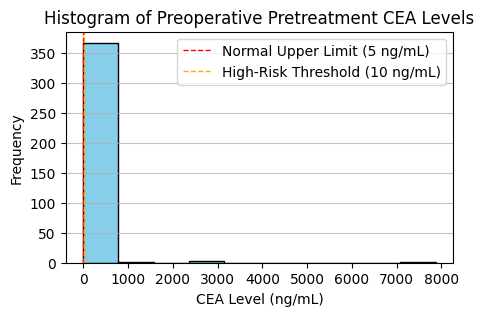

In [24]:
# Drop NaN values for the histogram
cea_levels = df['Preoperative Pretreatment Cea Level'].dropna()

# Plotting the histogram
plt.figure(figsize=(5, 3))
plt.hist(cea_levels, bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Preoperative Pretreatment CEA Levels')
plt.xlabel('CEA Level (ng/mL)')
plt.ylabel('Frequency')
plt.axvline(x=5, color='red', linestyle='dashed', linewidth=1, label='Normal Upper Limit (5 ng/mL)')
plt.axvline(x=10, color='orange', linestyle='dashed', linewidth=1, label='High-Risk Threshold (10 ng/mL)')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [25]:
# Example CEA levels column
cea_column = 'Preoperative Pretreatment Cea Level'  # Replace with your actual column name

# Determine clipping thresholds
lower_bound = df[cea_column].quantile(0.01)  # 1st percentile
upper_bound = df[cea_column].quantile(0.95)  # 95th percentile

# Clip values outside the normal range
df['Preoperative Pretreatment Cea Level'] = df['Preoperative Pretreatment Cea Level'].clip(lower=lower_bound, upper=upper_bound)

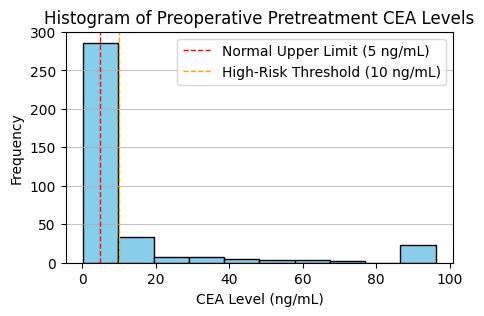

In [26]:
# Drop NaN values for the histogram
cea_levels = df['Preoperative Pretreatment Cea Level'].dropna()

# Plotting the histogram
plt.figure(figsize=(5, 3))
plt.hist(cea_levels, bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Preoperative Pretreatment CEA Levels')
plt.xlabel('CEA Level (ng/mL)')
plt.ylabel('Frequency')
plt.axvline(x=5, color='red', linestyle='dashed', linewidth=1, label='Normal Upper Limit (5 ng/mL)')
plt.axvline(x=10, color='orange', linestyle='dashed', linewidth=1, label='High-Risk Threshold (10 ng/mL)')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [27]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 578    │ │ string      │ 13    │                                                          │
│ │ Number of columns │ 18     │ │ float64     │ 3     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name           ┃ NA   ┃ NA %   ┃ mean    ┃ sd     ┃ p0     ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ Unnamed: 0            │    0 │      0 │   288.5 │    167 │      0 │ 144.2 │ 288.5 │ 432.8 │   577 │ ▇▇▇▇▇▇ │  │
│ │ g0_arrest             │    0 │      0 │  0.4896 │ 0.5003 │      0 │     0 │     0 │     1 │     1 │ ▇    ▇ │  │
│ │ Age At Initial        │    2 │   0.35 │   66.26 │  12.71 │     31 │    58 │    67 │    76 │    90 │ ▁▃▅▇▇▃ │  │
│ │ Pathologic Diagnosis  │      │        │         │        │        │       │       │       │       │        │  │
│ │ Lymph Node Examined   │   29 │   5.02 │      22 │  12.28 │      0 │    14 │    19 │    27 │   109 │  ▇▇▁   │  │
│ │ Count                 │      │        │         │        │        │       │       │       │       │        │  │
│ │ Preoperative          │  206 │  35.64 │   12.78 │  24.27 │ 0.3371 │   1.6 │  3.11 │ 8.928 │ 96.15 │ ▇    ▁ │  │
│ │ Pretreatment Cea      │      │        │         │        │        │       │       │       │       │        │  │
│ │ Level                 │      │        │         │        │        │       │       │       │       │        │  │
│ └───────────────────────┴──────┴────────┴─────────┴────────┴────────┴───────┴───────┴───────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                         ┃ NA      ┃ NA %       ┃ words per row           ┃ total words         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ PatientID                           │       0 │          0 │                       1 │                 578 │  │
│ │ Gender                              │       2 │       0.35 │                       1 │                 576 │  │
│ │ Race                                │     225 │      38.93 │                    0.99 │                 570 │  │
│ │ Other Dx                            │       2 │       0.35 │                       1 │                 580 │  │
│ │ Pathologic Stage                    │      19 │       3.29 │                     1.9 │                1118 │  │
│ │ Icd O 3 Histology                   │       2 │       0.35 │                       2 │                1178 │  │
│ │ Icd O 3 Site                        │       2 │       0.35 │                     2.4 │                1388 │  │
│ │ Person Neoplasm Cancer Status       │      67 │     

## Exploratory analysis

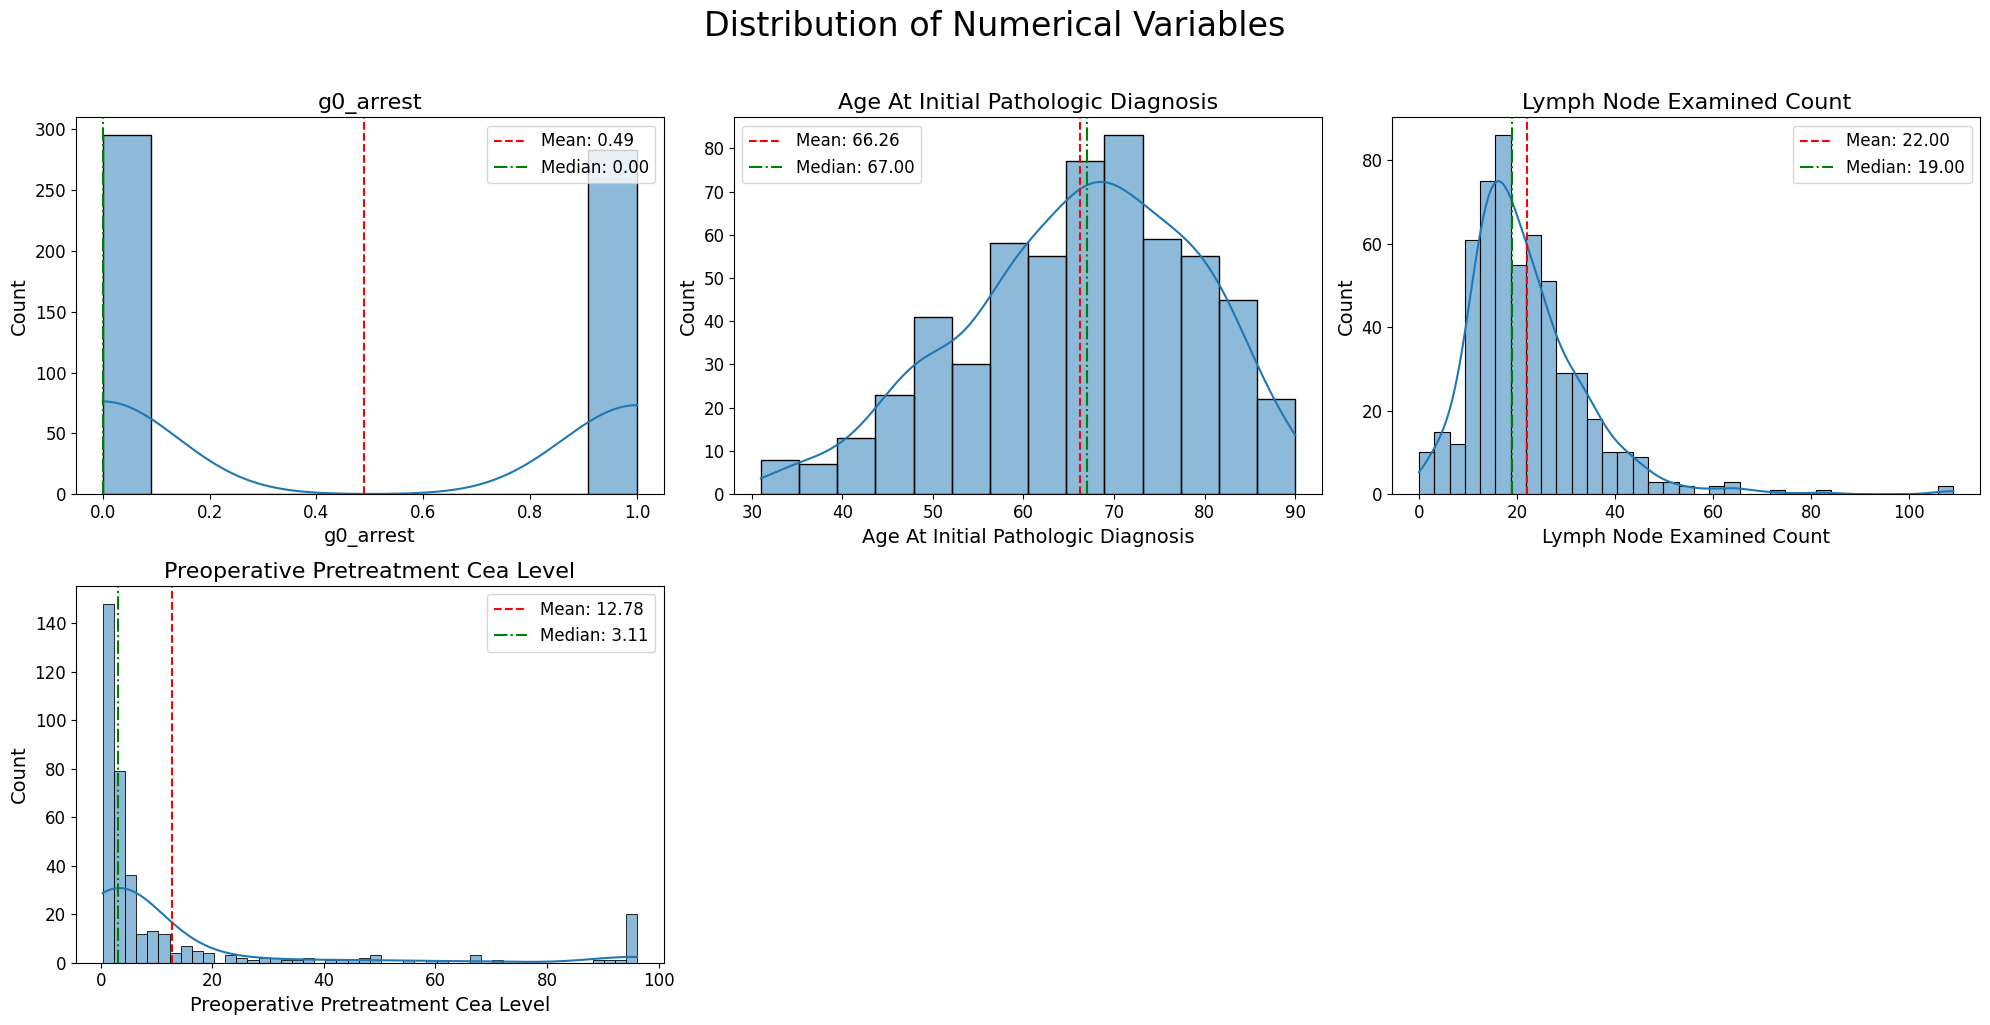

In [28]:
# # Numerical features
# num_feats=[col for col in df.columns if df[col].dtypes != 'object' and col != 'Unnamed: 0']

# # Plot distribution of numerical columns
# fig=plt.figure(figsize=(20,30))
# for i, col in enumerate(num_feats):
#     plt.subplot(len(num_feats),1,1*i+1)
#     sns.distplot(df[col])
    
# fig.tight_layout()
# plt.show()

# Numerical features
num_feats = [col for col in df.columns if df[col].dtypes != 'object' and col != 'Unnamed: 0']

# Calculate the number of rows and columns for the subplot grid
n = len(num_feats)
cols = 3
rows = math.ceil(n / cols)

# Create a larger figure with more space between subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
fig.suptitle('Distribution of Numerical Variables', fontsize=24, y=1.02)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Increase the space between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, col in enumerate(num_feats):
    ax = axes[i]
    
    # Plot histogram and KDE
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    
    # Add mean and median lines
    mean = df[col].mean()
    median = df[col].median()
    ax.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
    ax.axvline(median, color='g', linestyle='-.', label=f'Median: {median:.2f}')
    
    # Customize the plot
    ax.set_title(col, fontsize=16)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)

# Remove any unused subplots
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [29]:
print(df.columns)

Index(['Unnamed: 0', 'PatientID', 'g0_arrest', 'Gender',
       'Age At Initial Pathologic Diagnosis', 'Race', 'Other Dx',
       'Pathologic Stage', 'Icd O 3 Histology', 'Icd O 3 Site',
       'Lymph Node Examined Count', 'Person Neoplasm Cancer Status',
       'Venous Invasion', 'Lymphatic Invasion', 'History Of Colon Polyps',
       'Residual Tumor', 'Preoperative Pretreatment Cea Level',
       'Loss Expression Of Mismatch Repair Proteins By Ihc'],
      dtype='object')


In [30]:
categorical_vars = [col for col in df.columns if df[col].dtypes == 'object' and col != 'PatientID'] + ['g0_arrest'] # + ['Number Of First Degree Relatives With Cancer Diagnosis']


/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))


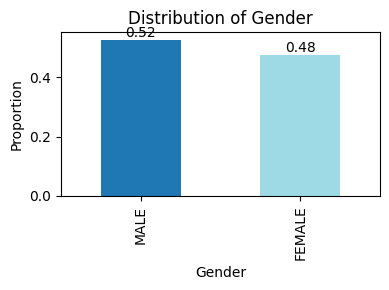

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))
/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


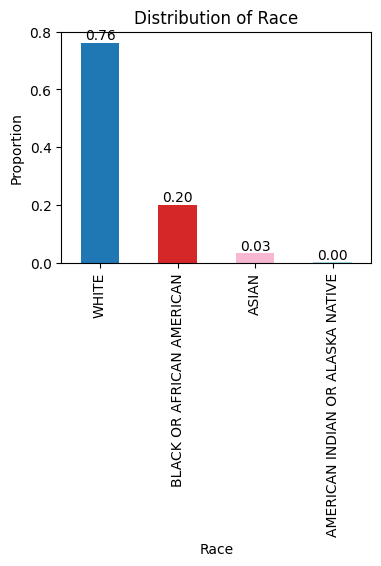

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))
/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


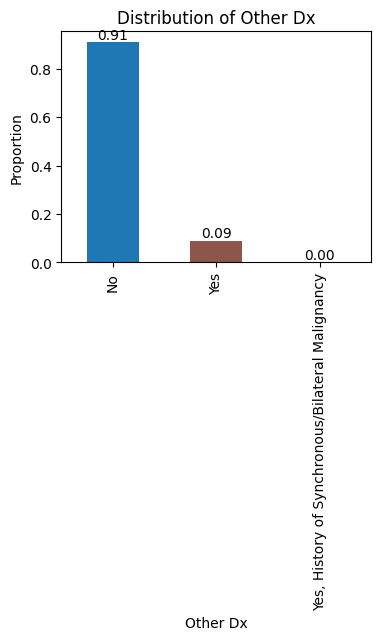

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))


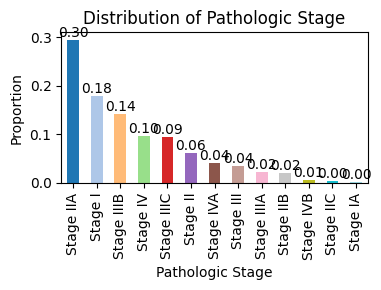

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))
/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


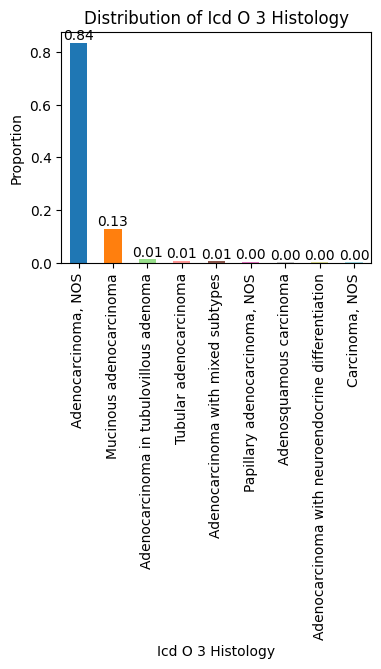

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))
/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


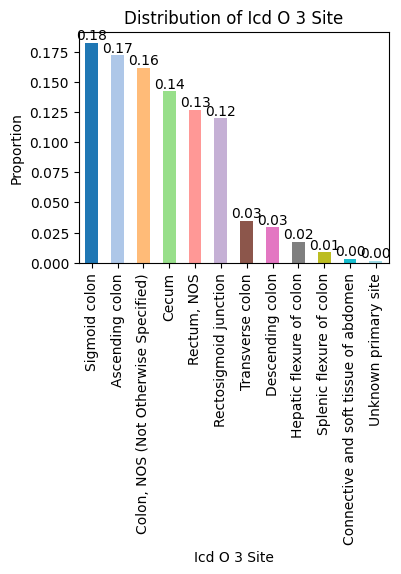

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))


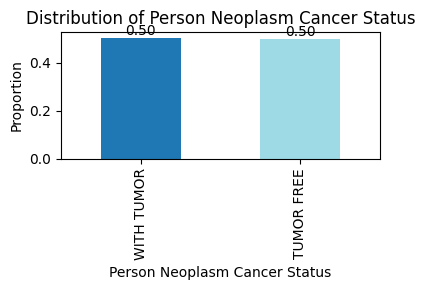

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))


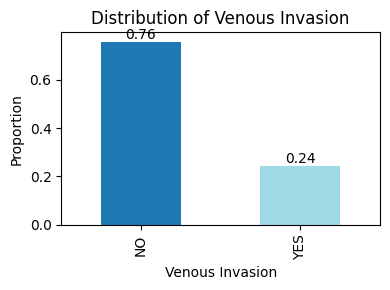

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))


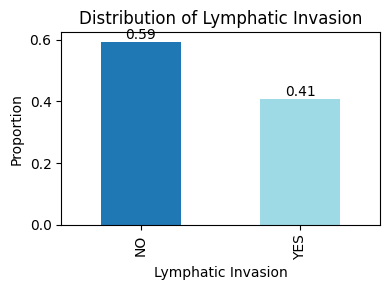

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))


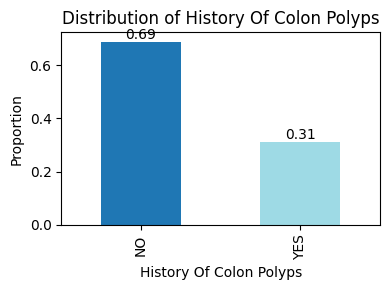

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))


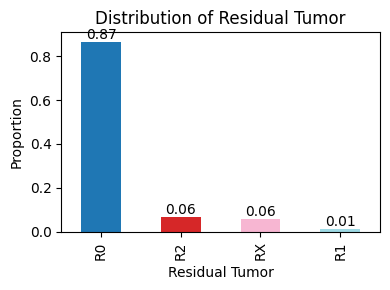

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))


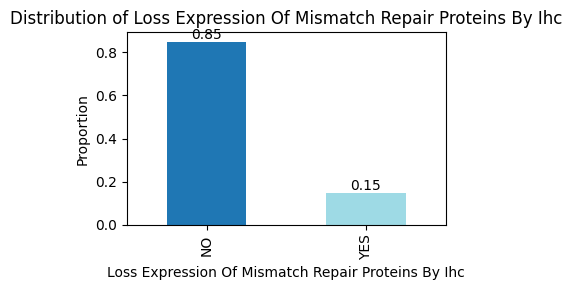

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_2006/1461556918.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))


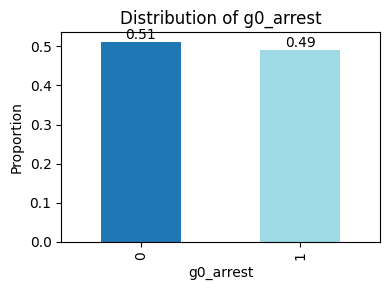

In [31]:
for col in categorical_vars:
    plt.figure(figsize=(4, 3))
    counts = df[col].value_counts(normalize=True)
    
    # Get a list of unique colors for the bars
    colors = plt.cm.get_cmap('tab20', len(counts))(np.linspace(0, 1, len(counts)))
    
    # Plot the bars with labels
    counts.plot(kind='bar', color=colors)
    plt.xticks(rotation=90)
    plt.xlabel(col)
    plt.ylabel('Proportion')
    plt.title(f'Distribution of {col}')
    
    # Add labels to the bars
    for i, v in enumerate(counts):
        plt.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()


## Group variables semantically the same

### Yes and Yes, History of Synchronous/Bilateral Malignancy

In [32]:
print(df['Other Dx'].value_counts())
df['Other Dx'] = df['Other Dx'].replace({
    'Yes, History of Synchronous/Bilateral Malignancy': 'Yes'
})

df['Other Dx'].value_counts()

Other Dx
No                                                  523
Yes                                                  52
Yes, History of Synchronous/Bilateral Malignancy      1
Name: count, dtype: int64


Other Dx
No     523
Yes     53
Name: count, dtype: int64

# Split-Dependent Preprocessing

In [33]:
df_train, df_val, df_test = train_val_test_split(df)

## Mode imputation

In [34]:
def imputation(split, train_split=df_train):
   mode_values = train_split.mode().iloc[0]

   imputed_split = split.fillna(mode_values)

   return imputed_split



print("before imputation:", sum(df_train.isna().sum()))
# print("Number of NaN values per feature: ")
# df_train_na = df_train.apply(mode_imputation, axis = 1)
df_train = imputation(df_train)
print("after imputation:", sum(df_train.isna().sum()))

before imputation: 694
after imputation: 0


In [35]:
df_train.head()
df_train.shape

(416, 18)

In [36]:
def group_balance(split, train_df = df_train):
    """
    Replacement map is computed on training split
    Training-split-based replacement map is applied to desired split, i.e., train, test, val. 
    """
    ### based on training stats
    
    ### RACE IMBALANCE: White
    split['Race'] = split['Race'].replace({
        value: 'NON-WHITE' for value in split['Race'].unique() if value not in train_df['Race'].value_counts(normalize=True).head(1).index
        }
    )

    ### ICD O 3 HISTOLOGY IMBALANCE: Adenocarcinoma, NOS
    split['Icd O 3 Histology'] = split['Icd O 3 Histology'].replace({
        value: 'Other' for value in split['Icd O 3 Histology'].unique() if value not in train_df['Icd O 3 Histology'].value_counts(normalize=True).head(1).index
        }
    )

    ### ICD O 3 SITE IMBALANCE: beyond Rectum, NOS
    split['Icd O 3 Site'] = split['Icd O 3 Site'].replace({
        value: 'Other' for value in split['Icd O 3 Site'].unique() if value not in train_df['Icd O 3 Site'].value_counts(normalize=True).head(6).index
        }
    )

    ### RESIDUAL TUMOR IMBALANCE: R0
    split['Residual Tumor'] = split['Residual Tumor'].replace({
        value: 'Other Stage' for value in split['Residual Tumor'].unique() if value not in train_df['Residual Tumor'].value_counts(normalize=True).head(1).index
        }
    )

    ### FIRST DEGREE RELATIVES WITH CANCER DIAGNOSIS: 0 ???

    
    return split


## Grouping variables to address class imbalance

In [37]:
print('before grouping: ', df_train['Race'].value_counts())  # is 'White'
df_train = group_balance(df_train)
print('after grouping: ', df_train['Race'].value_counts())


before grouping:  Race
WHITE                               359
BLACK OR AFRICAN AMERICAN            50
ASIAN                                 6
AMERICAN INDIAN OR ALASKA NATIVE      1
Name: count, dtype: int64
after grouping:  Race
WHITE        359
NON-WHITE     57
Name: count, dtype: int64


In [38]:
df_train['Icd O 3 Site'].value_counts()

Icd O 3 Site
Sigmoid colon                           83
Colon, NOS (Not Otherwise Specified)    69
Ascending colon                         68
Cecum                                   59
Rectosigmoid junction                   51
Rectum, NOS                             50
Other                                   36
Name: count, dtype: int64

In [39]:
# df_train.groupby(['Icd O 3 Site', 'g0_arrest']).size()
df_train['Icd O 3 Histology'].value_counts()

Icd O 3 Histology
Adenocarcinoma, NOS    349
Other                   67
Name: count, dtype: int64

In [40]:
# df[''].value_counts(dropna=False)
# df['Primary Lymph Node Presentation Assessment'].value_counts(dropna=False)
# df['Synchronous Colon Cancer Present'].value_counts(dropna=False)
df['Residual Tumor'].value_counts()
df_train['Residual Tumor'].value_counts()

Residual Tumor
R0             375
Other Stage     41
Name: count, dtype: int64

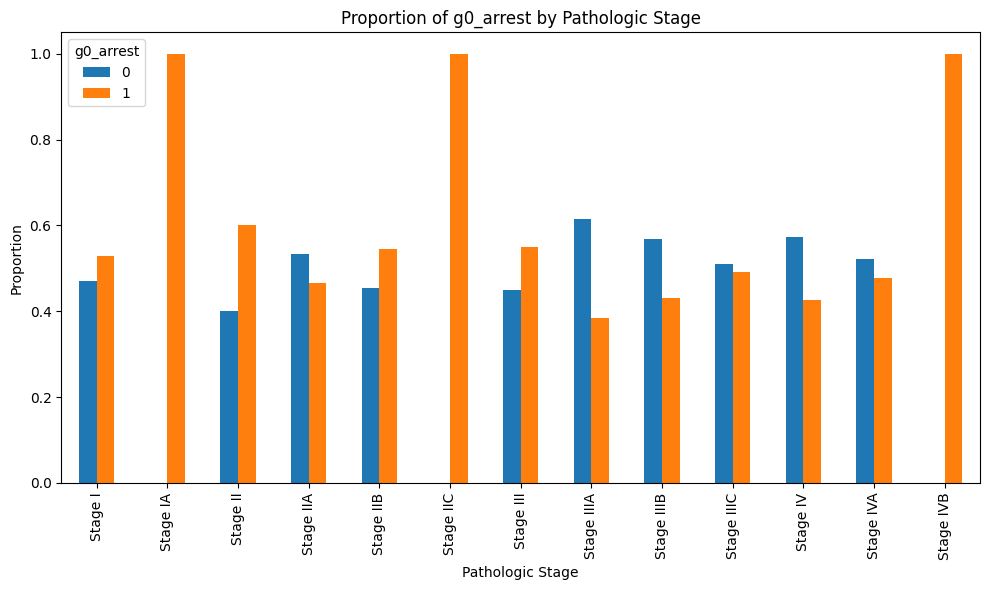

In [41]:
var_interest = 'Icd O 3 Site'
var_interest = 'History Of Colon Polyps'
var_interest = 'Age At Initial Pathologic Diagnosis'
var_interest = 'Lymphatic Invasion'
var_interest = 'Pathologic Stage'
# var_interest = 'Primary Lymph Node Presentation Assessment'
# var_interest = 'Residual Tumor'
# var_interest = 'Other Dx'
# var_interest = 'Race'




# Assuming your DataFrame is called 'df'
g0_arrest_counts = df.groupby([var_interest, 'g0_arrest']).size().unstack(fill_value=0)
g0_arrest_proportions = g0_arrest_counts.div(g0_arrest_counts.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
g0_arrest_proportions.plot(kind='bar', ax=ax)

ax.set_xlabel(f'{var_interest}')
ax.set_ylabel('Proportion')
ax.set_title(f'Proportion of g0_arrest by {var_interest}')
ax.legend(title='g0_arrest')

plt.tight_layout()
plt.show()


In [42]:
# var_interest = 'Race'
# # Assuming your DataFrame is called 'df'
# g0_arrest_counts = df_train.groupby([var_interest, 'g0_arrest']).size().unstack(fill_value=0)
# g0_arrest_proportions = g0_arrest_counts.div(g0_arrest_counts.sum(axis=1), axis=0)

# fig, ax = plt.subplots(figsize=(10, 6))

# # 1) Make the bars stacked
# g0_arrest_proportions.plot(kind='bar', stacked=True, ax=ax)

# # 2) Label each bar with the proportion
# bottom = 0
# for i in range(len(g0_arrest_proportions.columns)):
#     for j in range(len(g0_arrest_proportions)):
#         proportion = g0_arrest_proportions.iloc[j, i]
#         # ax.text(j, bottom + proportion / 2, f"{proportion:.2f}", ha='center', va='center', color='white')
#         x = j  # Use the row index as the x-coordinate
#         y = proportion  # Use the proportion value as the y-coordinate
#         ax.text(x, y, f"{proportion:.2f}", ha='center', va='bottom', color='black')
#     bottom += g0_arrest_proportions.iloc[:, i]

# ax.set_xlabel(var_interest)
# ax.set_ylabel('Proportion')
# ax.set_title('Proportion of g0_arrest by Icd 10')
# ax.legend(title='g0_arrest')

# plt.tight_layout()
# plt.show()

### convert from object to category

In [70]:
categorical_vars

['Gender',
 'Race',
 'Other Dx',
 'Pathologic Stage',
 'Icd O 3 Histology',
 'Icd O 3 Site',
 'Person Neoplasm Cancer Status',
 'Venous Invasion',
 'Lymphatic Invasion',
 'History Of Colon Polyps',
 'Residual Tumor',
 'Loss Expression Of Mismatch Repair Proteins By Ihc',
 'g0_arrest']

In [72]:
def cast_category(split, train_cat_vars=categorical_vars):
    split[train_cat_vars] = split[train_cat_vars].astype('category')
    # split = pd.get_dummies(split, columns=train_cat_vars, prefix= train_cat_vars)
    return split
# df_train[categorical_vars] = df_train[categorical_vars].astype('category')
df_train = cast_category(df_train)

In [73]:
df_train.dtypes

Age At Initial Pathologic Diagnosis                       float64
Lymph Node Examined Count                                 float64
Preoperative Pretreatment Cea Level                       float64
g0_arrest_1                                               float64
Gender_MALE                                               float64
Race_WHITE                                                float64
Other Dx_Yes                                              float64
Pathologic Stage_Stage II                                 float64
Pathologic Stage_Stage IIA                                float64
Pathologic Stage_Stage IIB                                float64
Pathologic Stage_Stage IIC                                float64
Pathologic Stage_Stage III                                float64
Pathologic Stage_Stage IIIA                               float64
Pathologic Stage_Stage IIIB                               float64
Pathologic Stage_Stage IIIC                               float64
Pathologic

### one hot encode categorical variables

In [60]:
def one_hot_encode(split, train_df):

    cats = [col for col in train_df.columns if train_df[col].dtypes == "category"]

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first') # pad categories which values coincidentally don't appear in val/test sets
    encoder.fit(train_df[cats])
    split_encoded = encoder.transform(split[cats])
    encoded_cols = encoder.get_feature_names_out(cats)
    split_encoded_df = pd.DataFrame(split_encoded, columns=encoded_cols)

    # pdb.set_trace()
    split_final = pd.concat([split.reset_index(drop=True), split_encoded_df], axis=1).drop(cats, axis=1)
    
    return split_final

df_train = one_hot_encode(df_train, df_train)

In [47]:
# def one_hot_encode(split):
#   cats = [col for col in split.columns if split[col].dtypes == 'category' and col != 'g0_arrest']
#   split = pd.get_dummies(split, columns=cats, prefix= cats, drop_first=True)
#   return split

# df_train = one_hot_encode(df_train)

In [48]:
# df['Circumferential Resection Margin'].unique()


In [62]:
df_train = df_train.drop(columns=['Unnamed: 0', 'PatientID'])

In [63]:
df_train.dtypes

Age At Initial Pathologic Diagnosis                       float64
Lymph Node Examined Count                                 float64
Preoperative Pretreatment Cea Level                       float64
g0_arrest_1                                               float64
Gender_MALE                                               float64
Race_WHITE                                                float64
Other Dx_Yes                                              float64
Pathologic Stage_Stage II                                 float64
Pathologic Stage_Stage IIA                                float64
Pathologic Stage_Stage IIB                                float64
Pathologic Stage_Stage IIC                                float64
Pathologic Stage_Stage III                                float64
Pathologic Stage_Stage IIIA                               float64
Pathologic Stage_Stage IIIB                               float64
Pathologic Stage_Stage IIIC                               float64
Pathologic

In [65]:
# Identify float columns
float_columns = ['Age At Initial Pathologic Diagnosis', 'Lymph Node Examined Count', 'Preoperative Pretreatment Cea Level']

# Initialize the StandardScaler
scaler = MinMaxScaler()



In [66]:
scaler.fit_transform(df_train[float_columns])

array([[0.88135593, 0.16513761, 0.05493094],
       [0.61016949, 0.2293578 , 0.01735633],
       [0.86440678, 0.26605505, 0.03196868],
       ...,
       [0.93220339, 0.11009174, 1.        ],
       [0.45762712, 0.21100917, 0.01944381],
       [0.88135593, 0.36697248, 1.        ]])

In [67]:

# Standardize only the float columns
df_train[float_columns] = scaler.fit_transform(df_train[float_columns])

In [68]:
print(df_train.shape)
df_train.head()

(416, 31)


,Age At Initial Pathologic Diagnosis,Lymph Node Examined Count,Preoperative Pretreatment Cea Level,g0_arrest_1,Gender_MALE,Race_WHITE,Other Dx_Yes,Pathologic Stage_Stage II,Pathologic Stage_Stage IIA,Pathologic Stage_Stage IIB,...,Icd O 3 Site_Other,Icd O 3 Site_Rectosigmoid junction,"Icd O 3 Site_Rectum, NOS",Icd O 3 Site_Sigmoid colon,Person Neoplasm Cancer Status_WITH TUMOR,Venous Invasion_YES,Lymphatic Invasion_YES,History Of Colon Polyps_YES,Residual Tumor_R0,Loss Expression Of Mismatch Repair Proteins By Ihc_YES
0,0.881356,0.165138,0.054931,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.610169,0.229358,0.017356,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,0.864407,0.266055,0.031969,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
3,0.728814,0.266055,1.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.644068,0.174312,0.232367,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [85]:
X_train = df_train.drop(columns=['g0_arrest_1'])
X_train.shape

(416, 30)

In [86]:
X_train.columns

Index(['Age At Initial Pathologic Diagnosis', 'Lymph Node Examined Count',
       'Preoperative Pretreatment Cea Level', 'Gender_MALE', 'Race_WHITE',
       'Other Dx_Yes', 'Pathologic Stage_Stage II',
       'Pathologic Stage_Stage IIA', 'Pathologic Stage_Stage IIB',
       'Pathologic Stage_Stage IIC', 'Pathologic Stage_Stage III',
       'Pathologic Stage_Stage IIIA', 'Pathologic Stage_Stage IIIB',
       'Pathologic Stage_Stage IIIC', 'Pathologic Stage_Stage IV',
       'Pathologic Stage_Stage IVA', 'Pathologic Stage_Stage IVB',
       'Icd O 3 Histology_Other', 'Icd O 3 Site_Cecum',
       'Icd O 3 Site_Colon, NOS (Not Otherwise Specified)',
       'Icd O 3 Site_Other', 'Icd O 3 Site_Rectosigmoid junction',
       'Icd O 3 Site_Rectum, NOS', 'Icd O 3 Site_Sigmoid colon',
       'Person Neoplasm Cancer Status_WITH TUMOR', 'Venous Invasion_YES',
       'Lymphatic Invasion_YES', 'History Of Colon Polyps_YES',
       'Residual Tumor_R0',
       'Loss Expression Of Mismatch Repair Prot

In [75]:
def feature_selection_scores(dataset=df_train, rf_classifier=None):
    
    X_train_ = dataset.drop(columns=['g0_arrest_1'])
    
    y_train = dataset['g0_arrest_1']

    scores = np.zeros(shape=X_train_.shape[1])

    # X_train_ = RobustScaler().fit_transform(X_train_)

    for i in tqdm(range(100)):    
        # Add random vector to training data
        random_vector       = np.random.rand(X_train_.shape[0], 1) # random samples from an uniform distribution over [0, 1)
        # random_vector = np.random.normal(loc=0, scale=0.1, size=(X_train_.shape[0], 1))

        X_train_with_random = np.concatenate((X_train_, random_vector), axis=1)

        if rf_classifier is None:
            rf_classifier = RandomForestClassifier(random_state=i) # Use default RF classifier

        rf_classifier.fit(X_train_with_random, y_train)

        feature_importances = rf_classifier.feature_importances_
        # pdb.set_trace()
        # Random vector feature importance
        threshold = feature_importances[-1]

        scores[np.argwhere(feature_importances > threshold)] += 1

    return scores

scores = feature_selection_scores(dataset=df_train, rf_classifier=xgb.XGBClassifier())


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:24<00:00,  4.13it/s]


In [81]:

'''
Divided into two functions to allow returning features with different threshold values without re-running the RandomForest classifier
'''
def feature_selection(scores, threshold=1):
    return np.argwhere(scores >= threshold).flatten()



# np.set_printoptions(threshold=np.inf)
features_idx = feature_selection(scores=scores)
features_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 12, 13, 14, 15, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [82]:
scores

array([ 55.,  66.,  59.,  53.,  98.,  59.,  26.,  23.,  27.,   0.,  34.,
         0.,  85.,  63.,  99.,  36.,   0.,  42.,  99.,  96.,  26.,  66.,
        33.,  83., 100.,  36.,  77.,  86.,  79., 100.])

In [87]:
X_train.columns

Index(['Age At Initial Pathologic Diagnosis', 'Lymph Node Examined Count',
       'Preoperative Pretreatment Cea Level', 'Gender_MALE', 'Race_WHITE',
       'Other Dx_Yes', 'Pathologic Stage_Stage II',
       'Pathologic Stage_Stage IIA', 'Pathologic Stage_Stage IIB',
       'Pathologic Stage_Stage IIC', 'Pathologic Stage_Stage III',
       'Pathologic Stage_Stage IIIA', 'Pathologic Stage_Stage IIIB',
       'Pathologic Stage_Stage IIIC', 'Pathologic Stage_Stage IV',
       'Pathologic Stage_Stage IVA', 'Pathologic Stage_Stage IVB',
       'Icd O 3 Histology_Other', 'Icd O 3 Site_Cecum',
       'Icd O 3 Site_Colon, NOS (Not Otherwise Specified)',
       'Icd O 3 Site_Other', 'Icd O 3 Site_Rectosigmoid junction',
       'Icd O 3 Site_Rectum, NOS', 'Icd O 3 Site_Sigmoid colon',
       'Person Neoplasm Cancer Status_WITH TUMOR', 'Venous Invasion_YES',
       'Lymphatic Invasion_YES', 'History Of Colon Polyps_YES',
       'Residual Tumor_R0',
       'Loss Expression Of Mismatch Repair Prot

In [88]:
X_train.columns[features_idx].to_list()

['Age At Initial Pathologic Diagnosis',
 'Lymph Node Examined Count',
 'Preoperative Pretreatment Cea Level',
 'Gender_MALE',
 'Race_WHITE',
 'Other Dx_Yes',
 'Pathologic Stage_Stage II',
 'Pathologic Stage_Stage IIA',
 'Pathologic Stage_Stage IIB',
 'Pathologic Stage_Stage III',
 'Pathologic Stage_Stage IIIB',
 'Pathologic Stage_Stage IIIC',
 'Pathologic Stage_Stage IV',
 'Pathologic Stage_Stage IVA',
 'Icd O 3 Histology_Other',
 'Icd O 3 Site_Cecum',
 'Icd O 3 Site_Colon, NOS (Not Otherwise Specified)',
 'Icd O 3 Site_Other',
 'Icd O 3 Site_Rectosigmoid junction',
 'Icd O 3 Site_Rectum, NOS',
 'Icd O 3 Site_Sigmoid colon',
 'Person Neoplasm Cancer Status_WITH TUMOR',
 'Venous Invasion_YES',
 'Lymphatic Invasion_YES',
 'History Of Colon Polyps_YES',
 'Residual Tumor_R0',
 'Loss Expression Of Mismatch Repair Proteins By Ihc_YES']

In [89]:


# Run skim
skim(X_train.iloc[:, features_idx])



╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 416    │ │ float64     │ 27    │                                                          │
│ │ Number of columns │ 27     │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name            ┃ NA  ┃ NA %  ┃ mean     ┃ sd      ┃ p0 ┃ p25     ┃ p50    ┃ p75    ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ Age At Initial         │   0 │     0 │   0.6078 │  0.2072 │  0 │  0.4746 │ 0.6271 │ 0.7627 │    1 │ ▁▂▅▇▇▃ │  │
│ │ Pathologic Diagnosis   │     │       │          │         │    │         │        │        │      │        │  │
│ │ Lymph Node Examined    │   0 │     0 │   0.1941 │  0.1139 │  0 │  0.1193 │ 0.1697 │ 0.2294 │    1 │  ▇▇▁   │  │
│ │ Count                  │     │       │          │         │    │         │        │        │      │        │  │
│ │ Preoperative           │   0 │     0 │   0.4491 │  0.4639 │  0 │ 0.02153 │ 0.1174 │      1 │    1 │ ▇▁   ▆ │  │
│ │ Pretreatment Cea Level │     │       │          │         │    │         │        │        │      │        │  │
│ │ Gender_MALE            │   0 │     0 │   0.5385 │  0.4991 │  0 │       0 │      1 │      1 │    1 │ ▇    ▇ │  │
│ │ Race_WHITE             │   0 │     0 │    0.863 │  0.3443 │  0 │       1 │      1 │      1 │    1 │ ▁    ▇ │  │
│ │ Other Dx_Yes           │   0 │     0 │  0.09135 │  0.2884 │  0 │       0 │      0 │      0 │    1 │ ▇    ▁ │  │
│ │ Pathologic Stage_Stage │   0 │     0 │  0.05769 │  0.2334 │  0 │       0 │      0 │      0 │    1 │   ▇    │  │
│ │ II                     │     │       │          │         │    │         │        │        │      │        │  │
│ │ Pathologic Stage_Stage │   0 │     0 │   0.3173 │   0.466 │  0 │       0 │      0 │      1 │    1 │ ▇    ▃ │  │
│ │ IIA                    │     │       │          │         │    │         │        │        │      │        │  │
│ │ Pathologic Stage_Stage │   0 │     0 │  0.01923 │  0.1375 │  0 │       0 │      0 │      0 │    1 │   ▇    │  │
│ │ IIB                    │     │       │          │         │    │         │        │        │      │        │  │
│ │ Pathologic Stage_Stage │   0 │     0 │  0.03125 │  0.1742 │  0 │       0 │      0 │      0 │    1 │   ▇    │  │
│ │ III                    │     │       │          │         │    │         │        │        │      │        │  │
│ │ Pathologic Stage_Stage │   0 │     0 │   0.1442 │  0.3517 │  0 │       0 │      0 │      0 │    1 │ ▇    ▁ │  │
│ │ IIIB                   │     │       │          │         │    │         │        │        │      │        │  │
│ │ Pathologic Stage_Stage │   0 │     0 │  0.09375 │  0.2918 │  0 │       0 │      0 │      0 │    1 │ ▇    ▁ │  │
│ │ IIIC                   │     │       │          │         │    │         │        │        │      │        │  │
│ │ Pathologic Stage_Stage │   0 │     0 │  0.09135 │  0.2884 │  0 │       0 │      0 │      0 │    1 │ ▇    ▁ │  │
│ │ IV                     │     │       │          │   

In [90]:
import sweetviz as sv

/Users/awxlong/anaconda3/envs/biomedai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [91]:
report = sv.analyze(X_train.iloc[:, features_idx])

[Summarizing dataframe]                      |          | [  0%]   00:00 -> (? left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)                  


In [92]:
report.show_html('sweetviz_report.html')

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [93]:
X_train.iloc[features_idx].describe()

,Age At Initial Pathologic Diagnosis,Lymph Node Examined Count,Preoperative Pretreatment Cea Level,Gender_MALE,Race_WHITE,Other Dx_Yes,Pathologic Stage_Stage II,Pathologic Stage_Stage IIA,Pathologic Stage_Stage IIB,Pathologic Stage_Stage IIC,...,Icd O 3 Site_Other,Icd O 3 Site_Rectosigmoid junction,"Icd O 3 Site_Rectum, NOS",Icd O 3 Site_Sigmoid colon,Person Neoplasm Cancer Status_WITH TUMOR,Venous Invasion_YES,Lymphatic Invasion_YES,History Of Colon Polyps_YES,Residual Tumor_R0,Loss Expression Of Mismatch Repair Proteins By Ihc_YES
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.0,27.000000,27.000000,27.0,...,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.585060,0.207271,0.410308,0.407407,0.888889,0.074074,0.0,0.370370,0.037037,0.0,...,0.111111,0.148148,0.148148,0.111111,0.629630,0.259259,0.370370,0.407407,0.814815,0.111111
std,0.226928,0.070020,0.451946,0.500712,0.320256,0.266880,0.0,0.492103,0.192450,0.0,...,0.320256,0.362014,0.362014,0.320256,0.492103,0.446576,0.492103,0.500712,0.395847,0.320256
min,0.000000,0.036697,0.001178,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.542373,0.160550,0.029881,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.610169,0.192661,0.090522,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.754237,0.270642,1.000000,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,1.000000,1.000000,1.000000,0.000000
max,0.881356,0.330275,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [94]:
X_train.describe()

,Age At Initial Pathologic Diagnosis,Lymph Node Examined Count,Preoperative Pretreatment Cea Level,Gender_MALE,Race_WHITE,Other Dx_Yes,Pathologic Stage_Stage II,Pathologic Stage_Stage IIA,Pathologic Stage_Stage IIB,Pathologic Stage_Stage IIC,...,Icd O 3 Site_Other,Icd O 3 Site_Rectosigmoid junction,"Icd O 3 Site_Rectum, NOS",Icd O 3 Site_Sigmoid colon,Person Neoplasm Cancer Status_WITH TUMOR,Venous Invasion_YES,Lymphatic Invasion_YES,History Of Colon Polyps_YES,Residual Tumor_R0,Loss Expression Of Mismatch Repair Proteins By Ihc_YES
count,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,...,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000
mean,0.607806,0.194138,0.449117,0.538462,0.862981,0.091346,0.057692,0.317308,0.019231,0.002404,...,0.086538,0.122596,0.120192,0.199519,0.581731,0.216346,0.377404,0.266827,0.901442,0.103365
std,0.207207,0.113909,0.463929,0.499119,0.344282,0.288448,0.233441,0.465989,0.137501,0.049029,...,0.281496,0.328368,0.325578,0.400120,0.493869,0.412249,0.485321,0.442834,0.298426,0.304802
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.474576,0.119266,0.021531,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.627119,0.169725,0.117399,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.762712,0.229358,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [95]:
[i for i in list(X_train.columns) if i not in list(X_train.columns[features_idx]) and i in list(X_train.columns)]

['Pathologic Stage_Stage IIC',
 'Pathologic Stage_Stage IIIA',
 'Pathologic Stage_Stage IVB']

In [ ]:
df['Pathologic Stage'].value_counts()
X_train.shape
features_selected = ['PatientID', 'Age At Initial Pathologic Diagnosis',
    'Lymph Node Examined Count',
    'Preoperative Pretreatment Cea Level',
    'Gender_MALE',
    'Race_WHITE',
    'Other Dx_Yes',
    'Pathologic Stage_Stage II',
    'Pathologic Stage_Stage IIA',
    'Pathologic Stage_Stage IIB',
    'Pathologic Stage_Stage III',
    'Pathologic Stage_Stage IIIB',
    'Pathologic Stage_Stage IIIC',
    'Pathologic Stage_Stage IV',
    'Pathologic Stage_Stage IVA',
    'Icd O 3 Histology_Other',
    'Icd O 3 Site_Cecum',
    'Icd O 3 Site_Colon, NOS (Not Otherwise Specified)',
    'Icd O 3 Site_Other',
    'Icd O 3 Site_Rectosigmoid junction',
    'Icd O 3 Site_Rectum, NOS',
    'Icd O 3 Site_Sigmoid colon',
    'Person Neoplasm Cancer Status_WITH TUMOR',
    'Venous Invasion_YES',
    'Lymphatic Invasion_YES',
    'History Of Colon Polyps_YES',
    'Residual Tumor_R0',
    'Loss Expression Of Mismatch Repair Proteins By Ihc_YES']
# df[features_selected]


# Putting everything together

In [ ]:
def preprocess(split, val_split, test_split):

    # global encoding icd_o_3 codes
    split = replace_icd_o_3_site(split, 'Icd O 3 Site')
    split = replace_icd_o_3_histology(split, 'Icd O 3 Histology')
    val_split = replace_icd_o_3_site(val_split, 'Icd O 3 Site')
    val_split = replace_icd_o_3_histology(val_split, 'Icd O 3 Histology')
    test_split = replace_icd_o_3_site(test_split, 'Icd O 3 Site')
    test_split = replace_icd_o_3_histology(test_split, 'Icd O 3 Histology')

    # global preprocessing: replace 'Unknown' with NA
    split = replace_unknown(split)
    val_split = replace_unknown(val_split)
    test_split = replace_unknown(test_split)
    
    # global preprocessing: drop columns with >45% NA rate 
    columns_to_drop = ['Weight', 'Circumferential Resection Margin', 'Perineural Invasion Present', 'Microsatellite Instability', 'Colon Polyps Present', 'Radiation Therapy', 'Primary Therapy Outcome Success', 'Non Nodal Tumor Deposits', 'Kras Mutation Found', 'Braf Gene Analysis Result', 'Postoperative Rx Tx', 'New Tumor Event After Initial Treatment', 'Prescribed Dose', 'Number Cycles', 'Measure Of Response']
    split = split.drop(columns=columns_to_drop)
    val_split = val_split.drop(columns=columns_to_drop)
    test_split = test_split.drop(columns=columns_to_drop)

    # global: clip biologically implausible Cea levels
    cea_column = 'Preoperative Pretreatment Cea Level'  # Replace with your actual column name

    # Determine clipping thresholds
    lower_bound = split[cea_column].quantile(0.01)  # 1st percentile
    upper_bound = split[cea_column].quantile(0.95)  # 95th percentile

    # Clip values outside the normal range
    split['Preoperative Pretreatment Cea Level'] = split['Preoperative Pretreatment Cea Level'].clip(lower=lower_bound, upper=upper_bound)
    val_split['Preoperative Pretreatment Cea Level'] = val_split['Preoperative Pretreatment Cea Level'].clip(lower=lower_bound, upper=upper_bound)
    test_split['Preoperative Pretreatment Cea Level'] = test_split['Preoperative Pretreatment Cea Level'].clip(lower=lower_bound, upper=upper_bound)
    
    # global
    split['Other Dx'] = split['Other Dx'].replace({
        'Yes, History of Synchronous/Bilateral Malignancy': 'Yes'
    })
    val_split['Other Dx'] = val_split['Other Dx'].replace({
        'Yes, History of Synchronous/Bilateral Malignancy': 'Yes'
    })
    test_split['Other Dx'] = test_split['Other Dx'].replace({
        'Yes, History of Synchronous/Bilateral Malignancy': 'Yes'
    })
    
    # train-set dependent preprocessing: use train-set's column-wise mode to impute missing values
    split = imputation(split, train_split = split)
    val_split = imputation(val_split, train_split = split)
    test_split = imputation(test_split, train_split = split)


    # train-set dependent preprocessing: clip categories based on train-set's column-wise, categorical variables' relative proportion
    split = group_balance(split, train_df = split)
    val_split = group_balance(val_split, train_df = split)
    test_split = group_balance(test_split, train_df = split)
    
    # global: ignore 'g0-arrest'
    split = split.loc[:, split.columns != 'g0_arrest']
    val_split = val_split.loc[:, val_split.columns != 'g0_arrest']
    test_split = test_split.loc[:, test_split.columns != 'g0_arrest']


    # global preprocessing: convert the object data type into categorical data type AFTER one-hot encoding which convert data types
    categorical_vars = [col for col in split.columns if split[col].dtypes == 'object' and col != 'PatientID'] # + ['g0_arrest'] 
    split = cast_category(split, train_cat_vars=categorical_vars)
    val_split = cast_category(val_split, train_cat_vars=categorical_vars)
    test_split = cast_category(test_split, train_cat_vars=categorical_vars)
    # pdb.set_trace()

    # global: one-hot encode
    X_train_split = one_hot_encode(split, split)
    X_val_split = one_hot_encode(val_split, split)
    X_test_split = one_hot_encode(test_split, split)
    # pdb.set_trace()
    
    
    # train-set dependent normalization
    scaler = MinMaxScaler()
    float_columns = ['Age At Initial Pathologic Diagnosis', 'Lymph Node Examined Count', 'Preoperative Pretreatment Cea Level'] # X_train_split.select_dtypes(include=['float64']).columns
    X_train_split[float_columns] = scaler.fit_transform(X_train_split[float_columns])
    X_val_split[float_columns] = scaler.transform(X_val_split[float_columns])
    X_test_split[float_columns] = scaler.transform(X_test_split[float_columns])


    # X_train_split = split.loc[:, split.columns != 'g0_arrest']
    # X_val_split = val_split.loc[:, val_split.columns != 'g0_arrest']
    # X_test_split = test_split.loc[:, test_split.columns != 'g0_arrest']
    # y_split = split['readmitted']

    features_selected = ['PatientID', 'Age At Initial Pathologic Diagnosis',
    'Lymph Node Examined Count',
    'Preoperative Pretreatment Cea Level',
    'Gender_MALE',
    'Race_WHITE',
    'Other Dx_Yes',
    'Pathologic Stage_Stage II',
    'Pathologic Stage_Stage IIA',
    'Pathologic Stage_Stage IIB',
    'Pathologic Stage_Stage III',
    'Pathologic Stage_Stage IIIB',
    'Pathologic Stage_Stage IIIC',
    'Pathologic Stage_Stage IV',
    'Pathologic Stage_Stage IVA',
    'Icd O 3 Histology_Other',
    'Icd O 3 Site_Cecum',
    'Icd O 3 Site_Colon, NOS (Not Otherwise Specified)',
    'Icd O 3 Site_Other',
    'Icd O 3 Site_Rectosigmoid junction',
    'Icd O 3 Site_Rectum, NOS',
    'Icd O 3 Site_Sigmoid colon',
    'Person Neoplasm Cancer Status_WITH TUMOR',
    'Venous Invasion_YES',
    'Lymphatic Invasion_YES',
    'History Of Colon Polyps_YES',
    'Residual Tumor_R0',
    'Loss Expression Of Mismatch Repair Proteins By Ihc_YES']
    
    X_train_split = X_train_split[features_selected]
    X_val_split = X_val_split[features_selected]
    # pdb.set_trace()
    X_test_split = X_test_split[features_selected]

    return X_train_split, X_val_split, X_test_split # , y_split

In [ ]:
# subdirs = os.listdir('/Users/awxlong/Desktop/my-studies/temp_data/CRC/TCGA-CRC/gdc_download_20240629_132916.799980/')
cohort_name = 'COAD'
task_name = 'g0_arrest'
# Parent directory containing subdirectories with XML files
# parent_directory = '/Users/awxlong/Desktop/my-studies/temp_data/CRC/TCGA-CRC/gdc_download_20240629_132916.799980/'
root_dir = '/Users/awxlong/Desktop/my-studies/hpc_exps/Data/'

df = pd.read_csv(f'{root_dir}{cohort_name}_WSI_clinical_g0_arrest_features.csv')


In [ ]:
df_train, df_val, df_test = train_val_test_split(df)

In [ ]:
X_train, X_val, X_test = preprocess(df_train, df_val, df_test)

/Users/awxlong/anaconda3/envs/biomedai/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
X_train.head()

,PatientID,Age At Initial Pathologic Diagnosis,Lymph Node Examined Count,Preoperative Pretreatment Cea Level,Gender_MALE,Race_WHITE,Other Dx_Yes,Pathologic Stage_Stage II,Pathologic Stage_Stage IIA,Pathologic Stage_Stage IIB,...,Icd O 3 Site_Other,Icd O 3 Site_Rectosigmoid junction,"Icd O 3 Site_Rectum, NOS",Icd O 3 Site_Sigmoid colon,Person Neoplasm Cancer Status_WITH TUMOR,Venous Invasion_YES,Lymphatic Invasion_YES,History Of Colon Polyps_YES,Residual Tumor_R0,Loss Expression Of Mismatch Repair Proteins By Ihc_YES
0,TCGA-AA-3877,0.882353,-0.041667,-0.044495,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,TCGA-4N-A93T,-0.058824,0.541667,-0.071259,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,TCGA-A6-2672,0.823529,0.875000,-0.060850,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
3,TCGA-AG-4001,0.352941,0.875000,0.931715,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,TCGA-AZ-6607,0.058824,0.041667,0.081890,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [ ]:
X_train['Gender_MALE'].value_counts()

Gender_MALE
1.0    224
0.0    192
Name: count, dtype: int64

In [ ]:
X_val['Gender_MALE'].value_counts()
X_val.shape

(104, 28)

In [ ]:
print(X_test.shape)
X_test.head()

(58, 28)


,PatientID,Age At Initial Pathologic Diagnosis,Lymph Node Examined Count,Preoperative Pretreatment Cea Level,Gender_MALE,Race_WHITE,Other Dx_Yes,Pathologic Stage_Stage II,Pathologic Stage_Stage IIA,Pathologic Stage_Stage IIB,...,Icd O 3 Site_Other,Icd O 3 Site_Rectosigmoid junction,"Icd O 3 Site_Rectum, NOS",Icd O 3 Site_Sigmoid colon,Person Neoplasm Cancer Status_WITH TUMOR,Venous Invasion_YES,Lymphatic Invasion_YES,History Of Colon Polyps_YES,Residual Tumor_R0,Loss Expression Of Mismatch Repair Proteins By Ihc_YES
0,TCGA-AD-6899,0.941176,0.125000,-0.040778,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,TCGA-EI-7004,-1.823529,0.958333,-0.062337,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,TCGA-AG-3909,0.058824,1.375000,0.931715,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,TCGA-F4-6463,-1.000000,-0.041667,0.931715,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,TCGA-F5-6465,-0.235294,-0.541667,0.931715,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [195]:
df.shape

(578, 33)